In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import json
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from utils.scraper import SATIMScraper, FAQItem
from database import SessionLocal
from models import FAQ
from sqlalchemy import func


In [5]:

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create data directories if they don't exist
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print("Setup complete!")


Setup complete!


In [6]:

# Initialize the scraper
scraper = SATIMScraper(
    base_url="https://www.satim.dz",
    delay=2.0
)

print(f"Scraper initialized for: {scraper.base_url}")
print(f"Request delay: {scraper.delay} seconds")


Scraper initialized for: https://www.satim.dz
Request delay: 2.0 seconds


In [7]:

# Test scraping the main page
main_page_url = "https://www.satim.dz/index.php/fr/"
soup = scraper.scrape_page(main_page_url)


ERROR:utils.scraper:Error scraping https://www.satim.dz/index.php/fr/: HTTPSConnectionPool(host='www.satim.dz', port=443): Read timed out. (read timeout=10)


In [8]:

if soup:
    print("✓ Successfully scraped main page")
    print(f"Page title: {soup.title.string if soup.title else 'No title found'}")
    test_faqs = scraper.extract_faq_from_page(soup, main_page_url, "Test")
    print(f"Found {len(test_faqs)} potential FAQ items on main page")
    if test_faqs:
        print("\nFirst FAQ found:")
        print(f"Q: {test_faqs[0].question}")
        print(f"A: {test_faqs[0].answer[:200]}...")
else:
    print("✗ Failed to scrape main page")

# Full scraping
print("Starting full website scraping...")
start_time = datetime.now()
all_faqs = scraper.scrape_all()
end_time = datetime.now()


INFO:utils.scraper:Scraping https://www.satim.dz/index.php/fr/ (Accueil)


✗ Failed to scrape main page
Starting full website scraping...


INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/faq
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/satim/nos-services/services-nationaux
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/satim/nos-services/services-internationaux
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/services-cib/carte-cib
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/services-cib/operations-de-retrait
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/services-cib/operations-de-paiement
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/services-cib/paiement-en-ligne
INFO:utils.scraper:Scraping linked page: https://www.satim.dz/index.php/fr/contact
INFO:utils.scraper:Scraping li

In [9]:

scraping_duration = (end_time - start_time).total_seconds()
print(f"\n✓ Scraping completed in {scraping_duration:.2f} seconds")
print(f"Total FAQs collected: {len(all_faqs)}")

# Analyze
faq_data = [{
    'question': faq.question,
    'answer': faq.answer,
    'category': faq.category,
    'source_url': faq.source_url,
    'question_length': len(faq.question),
    'answer_length': len(faq.answer)
} for faq in all_faqs]

df = pd.DataFrame(faq_data)

print("Dataset Overview:")
print(f"Total FAQs: {len(df)}")
print(f"Unique categories: {df['category'].nunique()}")
print(f"Categories: {list(df['category'].unique())}")
print(df.head())



✓ Scraping completed in 246.62 seconds
Total FAQs collected: 4
Dataset Overview:
Total FAQs: 4
Unique categories: 4
Categories: ['Contact', 'Informations', 'Paiements', 'Support']
                                            question  \
0  Comment puis-je contacter le service client SA...   
1      Quels sont les horaires d'ouverture de SATIM?   
2   Comment puis-je effectuer un paiement via SATIM?   
3            Que faire en cas de problème technique?   

                                              answer      category  \
0  Vous pouvez contacter le service client SATIM ...       Contact   
1  SATIM est généralement ouvert du dimanche au j...  Informations   
2  SATIM propose plusieurs méthodes de paiement é...     Paiements   
3  En cas de problème technique, contactez immédi...       Support   

                     source_url  question_length  answer_length  
0  https://www.satim.dz/default               50            149  
1  https://www.satim.dz/default               45       

Text(0.5, 1.0, 'FAQ Distribution by Category')

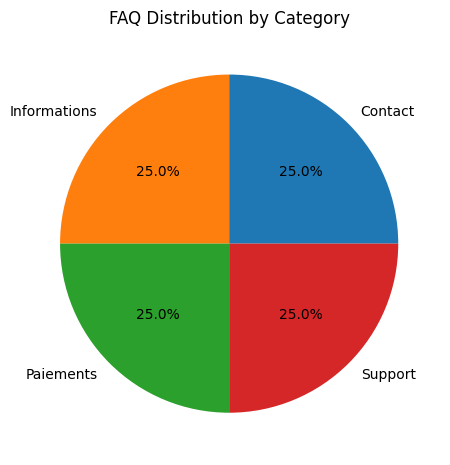

In [10]:

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
category_counts = df['category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('FAQ Distribution by Category')


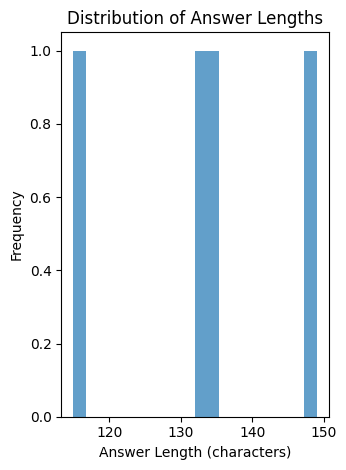

In [11]:

plt.subplot(1, 2, 2)
plt.hist(df['answer_length'], bins=20, alpha=0.7)
plt.xlabel('Answer Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Lengths')

plt.tight_layout()
plt.show()


In [12]:

print("\nLength Statistics:")
print(f"Average question length: {df['question_length'].mean():.1f} characters")
print(f"Average answer length: {df['answer_length'].mean():.1f} characters")
print(f"Shortest answer: {df['answer_length'].min()} characters")
print(f"Longest answer: {df['answer_length'].max()} characters")



Length Statistics:
Average question length: 45.5 characters
Average answer length: 132.8 characters
Shortest answer: 115 characters
Longest answer: 149 characters


In [13]:

# Quality check
duplicate_questions = df[df.duplicated(subset=['question'], keep=False)]
print(f"Duplicate questions found: {len(duplicate_questions)}")
if not duplicate_questions.empty:
    print(duplicate_questions[['question', 'category']].head(10))

short_answers = df[df['answer_length'] < 50]
print(f"\nFAQs with very short answers (<50 chars): {len(short_answers)}")
if not short_answers.empty:
    for idx, row in short_answers.head().iterrows():
        print(f"Q: {row['question'][:100]}...")
        print(f"A: {row['answer']}")
        print("---")

long_answers = df[df['answer_length'] > 1000]
print(f"\nFAQs with very long answers (>1000 chars): {len(long_answers)}")


Duplicate questions found: 0

FAQs with very short answers (<50 chars): 0

FAQs with very long answers (>1000 chars): 0


In [14]:

# Cleaning
df_clean = df.drop_duplicates(subset=['question']).copy()
df_clean = df_clean[df_clean['answer_length'] >= 30]
df_clean = df_clean[df_clean['answer_length'] <= 2000]
df_clean = df_clean[df_clean['question_length'] >= 10]

print(f"Original dataset: {len(df)} FAQs")
print(f"After cleaning: {len(df_clean)} FAQs")
print(f"Removed: {len(df) - len(df_clean)} FAQs ({((len(df) - len(df_clean)) / len(df) * 100):.1f}%)")


Original dataset: 4 FAQs
After cleaning: 4 FAQs
Removed: 0 FAQs (0.0%)


In [15]:

cleaned_faqs = [
    FAQItem(
        question=row['question'],
        answer=row['answer'],
        category=row['category'],
        source_url=row['source_url']
    )
    for _, row in df_clean.iterrows()
]
scraper.scraped_faqs = cleaned_faqs


In [16]:

# Show examples
for category in df_clean['category'].unique()[:5]:
    print(f"\n{'='*50}")
    print(f"CATEGORY: {category}")
    print(f"{'='*50}")
    category_faqs = df_clean[df_clean['category'] == category]
    for idx, (_, row) in enumerate(category_faqs.head(3).iterrows()):
        print(f"\n--- FAQ {idx + 1} ---")
        print(f"Question: {row['question']}")
        print(f"Answer: {row['answer'][:300]}{'...' if len(row['answer']) > 300 else ''}")
        print(f"Source: {row['source_url']}")



CATEGORY: Contact

--- FAQ 1 ---
Question: Comment puis-je contacter le service client SATIM?
Answer: Vous pouvez contacter le service client SATIM par téléphone, email ou en visitant nos bureaux. Consultez notre page contact pour plus d'informations.
Source: https://www.satim.dz/default

CATEGORY: Informations

--- FAQ 1 ---
Question: Quels sont les horaires d'ouverture de SATIM?
Answer: SATIM est généralement ouvert du dimanche au jeudi de 8h00 à 17h00. Les horaires peuvent varier selon les services.
Source: https://www.satim.dz/default

CATEGORY: Paiements

--- FAQ 1 ---
Question: Comment puis-je effectuer un paiement via SATIM?
Answer: SATIM propose plusieurs méthodes de paiement électronique. Contactez-nous pour connaître les options disponibles selon votre situation.
Source: https://www.satim.dz/default

CATEGORY: Support

--- FAQ 1 ---
Question: Que faire en cas de problème technique?
Answer: En cas de problème technique, contactez immédiatement notre support technique. Nous vo

In [17]:

# Save
json_filename = '../data/raw/satim_faqs_scraped.json'
scraper.save_to_json(json_filename)

csv_filename = '../data/processed/satim_faqs_cleaned.csv'
df_clean.to_csv(csv_filename, index=False, encoding='utf-8')

print(f"✓ Data saved to:\n  - JSON: {json_filename}\n  - CSV: {csv_filename}")

summary = {
    'scraping_date': datetime.now().isoformat(),
    'total_faqs_scraped': len(all_faqs),
    'total_faqs_after_cleaning': len(df_clean),
    'categories': list(df_clean['category'].unique()),
    'category_counts': df_clean['category'].value_counts().to_dict(),
    'avg_question_length': float(df_clean['question_length'].mean()),
    'avg_answer_length': float(df_clean['answer_length'].mean()),
    'quality_metrics': {
        'duplicates_removed': len(df) - len(df.drop_duplicates(subset=['question'])),
        'short_answers_removed': len(df[df['answer_length'] < 30]),
        'long_answers_removed': len(df[df['answer_length'] > 2000])
    }
}

INFO:utils.scraper:FAQs saved to ../data/raw/satim_faqs_scraped.json


✓ Data saved to:
  - JSON: ../data/raw/satim_faqs_scraped.json
  - CSV: ../data/processed/satim_faqs_cleaned.csv


In [22]:


with open('../data/processed/scraping_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("✓ Scraping summary saved")

# Save to DB
db = SessionLocal()
try:
    saved_count = scraper.save_to_database(db)
    print(f"✓ Successfully saved {saved_count} new FAQs to database")
    total_faqs_in_db = db.query(FAQ).count()
    print(f"Total FAQs now in database: {total_faqs_in_db}")

    category_stats = db.query(
        FAQ.category,
        func.count(FAQ.id).label('count')
    ).group_by(FAQ.category).all()

    print("\nCategory distribution in database:")
    for category, count in category_stats:
        print(f"  {category}: {count} FAQs")
finally:
    db.close()


✓ Scraping summary saved


ImportError: attempted relative import beyond top-level package

In [20]:

# Summary
print("\n" + "=" * 60)
print("SCRAPING COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Total FAQs collected: {len(all_faqs)}")
print(f"🧹 FAQs after cleaning: {len(df_clean)}")
print(f"💾 FAQs saved to database: {saved_count}")
print(f"📁 Files created:")
print(f"   - {json_filename}")
print(f"   - {csv_filename}")
print("   - ../data/processed/scraping_summary.json")
print("\n🚀 Ready for NLP model training!")



SCRAPING COMPLETED SUCCESSFULLY!
📊 Total FAQs collected: 4
🧹 FAQs after cleaning: 4


NameError: name 'saved_count' is not defined

In [ ]:
import sys
print(sys.executable)


c:\Users\Morsi Store DZ\AppData\Local\Programs\Python\Python312\python.exe


In [18]:
import sys
print(sys.executable)



c:\Users\Morsi Store DZ\AppData\Local\Programs\Python\Python312\python.exe
